In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

INTERESTING_TRACES = [ "std_phon_trace", "clean_trace"]


df = pd.read_csv(DF_PREPROC_FILE)
traces = dict()
for t in INTERESTING_TRACES:
    traces[t] = np.load(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), allow_pickle=True)

# traces["syll_labels"] = np.repeat(np.arange(7), len(traces["syllables_fourier"])//7)
# print(traces["syll_labels"].shape)

SAMPLING_RATE = 48_000/8

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Short-time Fourier transform

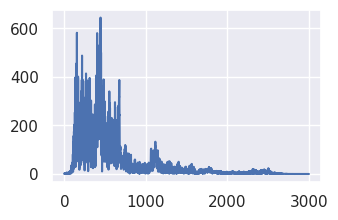

In [49]:
from scipy.fft import fft, ifft, fftfreq

signal = traces["clean_trace"][6]
signal = signal[~np.isnan(signal)]

N, T = len(signal), 1.0/SAMPLING_RATE

spectrum = np.abs(fft(signal)[:N//2])
freqs = fftfreq(N, T)[:N//2]

plt.plot(freqs, spectrum)

Audio split in 50 windows
Each window is 48.50 millisec long
Max frequency is 3.0 kHz
145


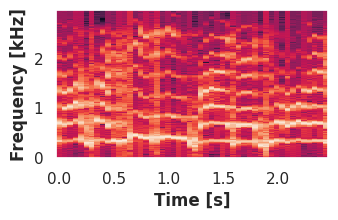

In [50]:
track_index = 1500
signal = traces["clean_trace"][track_index]
signal = signal[~np.isnan(signal)]

M, N, T = 50, len(signal), 1.0/SAMPLING_RATE

windows = np.array_split(signal, M)
winlen = np.min([len(w) for w in windows])

print(f"Audio split in {len(windows)} windows")
print(f"Each window is {winlen/SAMPLING_RATE*1e3:.2f} millisec long")
print(f"Max frequency is {np.max(freqs)*1e-3:.1f} kHz")

STFT = np.zeros((winlen//2, M))

for i, part in enumerate(windows):
    regularized_window = np.hamming(len(part))*part
    window_spectrum = np.abs(fft(regularized_window)[:winlen//2])**2
    STFT[:winlen//2, i] = np.log(window_spectrum/np.sum(window_spectrum))
    
TT, FF = np.linspace(0, N/SAMPLING_RATE, M), fftfreq(winlen, T)[:winlen//2]*1e-3
print(winlen//2)
TT, FF = np.meshgrid(TT, FF)    
plt.pcolormesh(TT.T, FF.T, STFT.T)

plt.grid(ls="")
# plt.axis("off")
plt.xlabel("Time [s]");
plt.ylabel("Frequency [kHz]");
# plt.title(f"{df.sex[track_index]} {df.vocal_channel[track_index]} STFT");
plt.savefig('../images/fourier_STFT.pdf')

## Spectral statistics timeseries

Since the stft returns a matrix (bad), It is possible to extract a statictical feature from the spectrum of each window, such as the spectral centroid

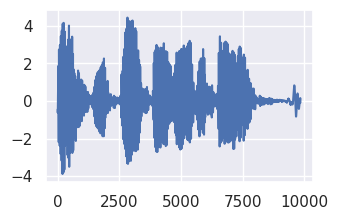

In [55]:
plt.plot(traces["clean_trace"][0])

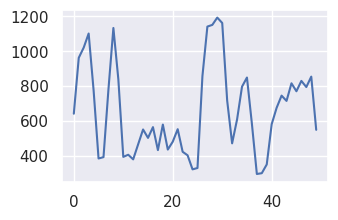

In [51]:
stft_centroid = np.zeros(M)
TT, FF = np.linspace(0, N/SAMPLING_RATE, M), fftfreq(winlen, T)[:winlen//2]

for i in range(M):
    # get a distribution from STFT
    energy_density = np.exp(STFT[:, i]) - np.min(np.exp(STFT[:, i])) # offsets the minimum to be zero
    energy_density /= np.sum(energy_density)         # normalizes
#     plt.plot(FF, energy_density)

    # gets weighted mean
    stft_centroid[i] = np.sum(FF*energy_density)
    
plt.plot(stft_centroid)

## For the full dataset

Since the tracks have different length, the fourier coefficients have different length.
What is possible to do is to bin the spectrum in a range of freqs and then sum the squares (mean energy).

In [52]:
# def bin_spectral_energy(spectrum_energy, n_bins, max_freq, sampling_rate=SAMPLING_RATE, plot_check=False):
#     if len(spectrum_energy) < n_bins:
#         raise ValueError(f"too few frequencies to bin (spectrum has {len(spectrum_energy)})")
    
#     T = 1.0/sampling_rate
    
#     # Removes higher-pitch part that makes bins unequal
#     ss = spectrum_energy[:len(spectrum_energy) - (len(spectrum_energy)%n_bins) ]
#     ffs = fftfreq(2*len(ss), T)[:len(ss)]

#     ff_bin_edges = np.linspace(0, max_freq, n_bins + 1, endpoint=True)
    
#     binned_energies = np.zeros(n_bins)
#     for i in range(n_bins):
#         binned_energies[i] = np.mean(ss[(ffs >= ff_bin_edges[i])&(ffs < ff_bin_edges[i+1])] )
    
#     if plot_check:
#         plt.plot(ffs, ss, ls="", marker=".", ms=3,alpha=0.5, label=f"trace length = {2*len(ss)}")
#         plt.step(ff_bin_edges[:-1],binned_energies, where="post")
#         plt.yscale("log")
#         plt.xlabel("Frequency [Hz]")
#     return binned_energies

# # Test track
# fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
# test_track_index = 1500
# signal = traces["clean_trace"][test_track_index]
# signal = signal[~np.isnan(signal)]

# part = np.array_split(signal, 23)[0]
# regularized_window = np.hamming(len(part))*part
# window_spectrum = np.abs(fft(regularized_window)[:len(part)//2])**2
# print(len(part))
# u = np.log(bin_spectral_energy(window_spectrum, 45, 3000, plot_check=True))

# # Comparison
# # test_track_index = 1800
# # signal = traces["clean_trace"][test_track_index]
# # signal = signal[~np.isnan(signal)]

# # part = np.array_split(signal, 23)[0]
# # regularized_window = np.hamming(len(part))*part
# # window_spectrum = np.abs(fft(regularized_window)[:len(part)//2])**2
# # print(len(part))
# # u = np.log(bin_spectral_energy(window_spectrum, 45, 3000, plot_check=True))

# # plt.gcf().legend()
# plt.savefig("../images/fourier_binning.pdf")

In [57]:
from djanloo_fourier import STFTransformer

transf = STFTransformer()
transf.fit_transform(traces["clean_trace"])

/home/djanloo/Desktop/DM2/TimeSeries/djanloo_fourier.py:63: UserWarning: time bins/spectral bins not specified, setting balanced bins
  warnings.warn("time bins/spectral bins not specified, setting balanced bins")


shortest trace has length 5976


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2452/2452 [03:25<00:00, 11.95it/s]


(array([[[ -0.97571019,   0.09007881,  -9.03730127, ...,  -0.49493913,
           -0.1379821 ,   0.43490741],
         [ -0.73082232,  -2.01956306,  -0.70377381, ...,   2.93136726,
            2.79197106,   2.70404263],
         [  0.02818383,  -0.8921617 ,  -0.03395351, ...,   1.91233186,
           -2.00679832,  -0.14064787],
         ...,
         [ -0.50586349,   3.59886095,   1.92613376, ...,  -7.98873423,
           -8.0589179 ,  -7.48803836],
         [  6.92643069,   7.00832305,   5.82500918, ...,  -6.65574755,
           -6.64543077,  -6.80681228],
         [  3.25751944,   5.11022434,   5.793117  , ...,  -6.74823715,
           -6.53643884,  -6.92038836]],
 
        [[ -3.38272751,   4.69888365,   7.50567849, ...,  -6.15977827,
           -6.19333966,  -6.20823395],
         [ -0.83074564,   5.11652197,   8.05535847, ...,  -3.20099825,
           -3.2326835 ,  -3.23984879],
         [ -1.35404243,   5.41491699,   8.19055808, ...,  -7.49825959,
           -7.47969679,  -7.6408

In [60]:
transf.report(traces["clean_trace"])

Time bins = 54, Spectral bins = 54
min length of window is roughly 558
max number of Fourier coeffs is 279


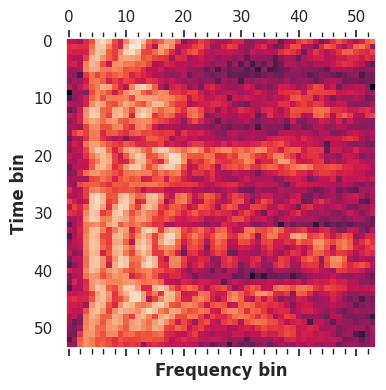

In [63]:
one_curve = transf.STFT[2]
plt.matshow(one_curve)
plt.grid(ls="")
plt.ylabel("Time bin")
plt.xlabel("Frequency bin");

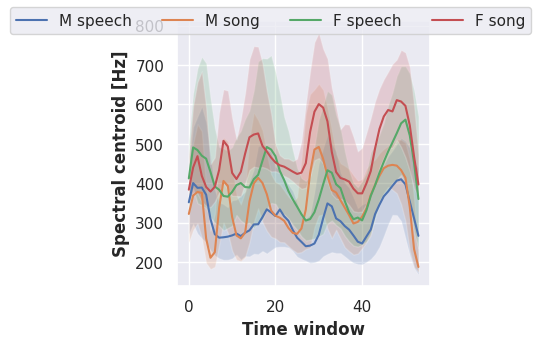

In [70]:
fig, ax = plt.subplots(figsize=default_style.HALFSIZE_FIGURE)
for s in ["M", "F"]:
    for vc in ["speech","song"]:
        subsamp = transf.spectral_centroid[(df.vocal_channel == vc)&(df.sex==s)]
        low, mid, upp = np.quantile(subsamp, [.25, .5, .75], axis=0)
        
        plt.plot(mid, label=f"{s} {vc}")
        plt.fill_between(range(transf.n_time_bins), low, upp,alpha=0.2)
fig.legend(ncols = 4, loc="upper center")
plt.ylabel("Spectral centroid [Hz]")
plt.xlabel("Time window");
fig.tight_layout()

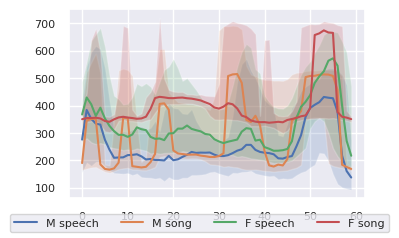

In [48]:
fig, ax = plt.subplots()
for s in ["M", "F"]:
    for vc in ["speech","song"]:
        subsamp = traces["spectral_mode"][(df.vocal_channel == vc)&(df.sex==s)]
        low, mid, upp = np.quantile(subsamp, [.25, .5, .75], axis=0)
        
        plt.plot(mid, label=f"{s} {vc}")
        plt.fill_between(range(N_TIME_BINS), low, upp,alpha=0.2)
fig.legend(ncols = 4, loc="lower center")

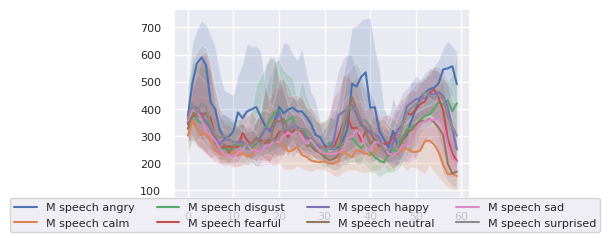

In [49]:
fig, ax = plt.subplots()
for s in ["M"]:
    for vc in ["speech"]:
        for emo in np.unique(df[(df.sex==s)&(df.vocal_channel == vc)].emotion):
        
            subsamp = traces["spectral_centroid"][(df.vocal_channel == vc)&(df.sex==s)&(df.emotion==emo)]
            low, mid, upp = np.quantile(subsamp, [.25, .5, .75], axis=0)

            plt.plot(mid, label=f"{s} {vc} {emo}")
            plt.fill_between(range(N_TIME_BINS), low, upp,alpha=0.2)
fig.legend(ncols = 4, loc="lower center")

In [71]:
np.save(os.path.join(TS_PREPROC_FOLDER, f"full_stft.npy"), transf.STFT)
np.save(os.path.join(TS_PREPROC_FOLDER, f"spectral_centroid.npy"), transf.spectral_centroid)
np.save(os.path.join(TS_PREPROC_FOLDER, f"spectral_mode.npy"), transf.spectral_mode)

## Check umap on spectral centroids

In [73]:
from umap import UMAP

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualen

In [74]:
X = transf.spectral_centroid

reducer = UMAP(n_neighbors=10)
embedding = reducer.fit_transform(X)

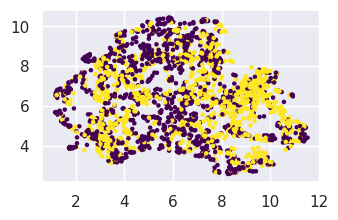

In [75]:
plt.scatter(*embedding.T, s=5, c=(df.emotion=="calm")|(df.emotion=="sad")|(df.emotion=="fearful"), cmap="viridis")

## Test to see the evolution in fourier space

In [79]:
X = transf.STFT

# Merges all tracks together
# In this way UMAP learns the manifold of spectral vectors
# independently from the track
X = X.reshape(-1,transf.n_spectral_bins)

print(X.shape)

(132408, 54)


In [80]:
reducer = UMAP(n_neighbors=10)

N_SUBSAMP = 10_000
shuffled_subsamp = np.arange(len(X))
np.random.shuffle(shuffled_subsamp)
shuffled_subsamp = shuffled_subsamp[:N_SUBSAMP]

all_spectral_coeff = reducer.fit_transform(X[shuffled_subsamp])

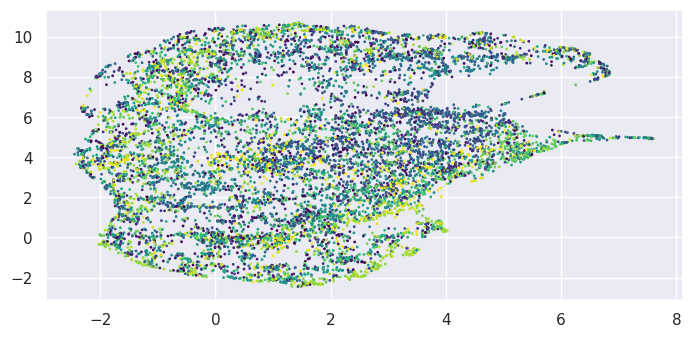

In [82]:
fig, ax =plt.subplots(figsize=default_style.FULLSIZE_FIGURE)
# colors = np.repeat(df.statement == "kids", N_TIME_BINS).values[shuffled_subsamp]
colors = np.tile(range(transf.n_time_bins), len(df))[shuffled_subsamp]
plt.scatter(*all_spectral_coeff.T, s=1, alpha=1, c= colors, cmap="viridis")

In [ ]:
from sklearn.manifold import Isomap
reducer = Isomap(n_neighbors=10)

all_spectral_coeff = reducer.fit_transform(X[shuffled_subsamp])

In [ ]:
fig, ax =plt.subplots(figsize=default_style.FULLSIZE_FIGURE)
colors = np.repeat(df.vocal_channel == "song", transf.n_time_bins).values[shuffled_subsamp]
plt.scatter(*all_spectral_coeff.T, s=1, alpha=0.8, c= colors, cmap="viridis")

In [ ]:
# Now returns to treat each track as a timeseries of points in spectral space
X = X.reshape(-1, transf.n_time_bins, transf.n_spectral_bins)

# Predicts the path in 2D that corresponds to a trace
embedding = reducer.transform(X[1500])

In [ ]:
plt.plot(*embedding.T, color="k", lw=1)
plt.scatter(*embedding.T, c=range(N_TIME_BINS), zorder=2)
plt.colorbar()

plt.scatter(*all_spectral_coeff.T, s=1, alpha=0.3, c= colors, cmap="viridis")

In [ ]:
colors = np.tile(range(transf.n_t), len(df))[shuffled_subsamp]
plt.plot(*embedding.T, color="k", lw=1)
plt.scatter(*embedding.T, c=range(N_TIME_BINS), zorder=2)
plt.colorbar()

plt.scatter(*all_spectral_coeff.T, s=1, alpha=0.3, c= colors, cmap="viridis")

In [ ]:
from djanloo_fourier import STFTransformer

transf = STFTransformer(n_time_bins=None, 
                        n_spectral_bins=None, 
                        max_frequency=3000, 
                        sampling_rate=SAMPLING_RATE)

# Makes a square STFT
transf.balance_n_coeff(traces["clean_trace"])
transf.report(traces["clean_trace"])
STFT, sc = transf.fit_transform(traces["clean_trace"])